# Clusterring Data
Source : https://github.com/lucas-de-sa/national-anthems-lustering/blob/master/Cluster_Anthems.ipynb

In [17]:
import nltk
import sklearn
print('The nltk version is {}.'. format(nltk. __version__))
print('The scikit-learn version is {}.'. format(sklearn. __version__))

The nltk version is 3.7.
The scikit-learn version is 1.0.2.


In [1]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

In [2]:
# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

In [3]:
# K-Means
from sklearn import cluster

In [4]:
# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

In [5]:
# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

In [40]:
# read the data
data = pd.read_csv('2021_Cities_Water_Security_Risks-tieas.csv', encoding='utf-8')
data.columns = map(str.lower, data.columns)
data.head(6)

questionnaire_name  account_number             account_name  \
0        Cities 2021            1093      City of Atlanta, GA   
1        Cities 2021            1093      City of Atlanta, GA   
2        Cities 2021            1184       City of Austin, TX   
3        Cities 2021            1499  Ajuntament de Barcelona   
4        Cities 2021            1499  Ajuntament de Barcelona   
5        Cities 2021            1499  Ajuntament de Barcelona   

                    country     cdp_region       parentsection       section  \
0  United States of America  North America  14. Water Security  Water Supply   
1  United States of America  North America  14. Water Security  Water Supply   
2  United States of America  North America  14. Water Security  Water Supply   
3                     Spain         Europe  14. Water Security  Water Supply   
4                     Spain         Europe  14. Water Security  Water Supply   
5                     Spain         Europe  14. Water Security  Water Supply   

  question_number                                      question_name  \
0           14.2a  Please identify the risks to your city’s water...   
1           14.2a  Please identify the risks to your city’s water...   
2           14.2a  Please identify the risks to your city’s water...   
3           14.2a  Please identify the risks to your city’s water...   
4           14.2a  Please identify the risks to your city’s water...   
5           14.2a  Please identify the risks to your city’s water...   

   row_number water_security_risk_drivers  anticipated_timescale  \
0           1      Increased water stress   Short-term (by 2025)   
1           2         Higher water prices                Current   
2           1      Increased water stress   Short-term (by 2025)   
3           1      Increased water stress                Current   
4           2     Declining water quality  Medium-term (by 2050)   
5           3       Severe weather events                Current   

  estimated_magnitude_of_potential_impact estimated_probability_of_impact  \
0                                 Serious                             NaN   
1                                 Serious                             NaN   
2                       Extremely serious                            High   
3                                 Serious                     Medium-high   
4                            Less Serious                          Medium   
5                                 Serious                     Medium-high   

                                    risk_description  
0  The city depends on one river for water supply...  
1  The water cost burden is felt across all ZIP c...  
2  Central Texas is drought prone and we depend o...  
3  The downscaling of the climate projections at ...  
4  A reduction in water resources availability  c...  
5  In terms of water supply, rivers floods could ...

In [7]:
# corpus processing

regions = ['North America', 'Europe', 'Southeast Asia and Oceania',
       'East Asia', 'Africa', 'Latin America', 'South and West Asia',
       'Middle East']
data = data.loc[data['cdp_region'].isin(regions)]
data.head(6)


questionnaire_name  account_number             account_name  \
0        Cities 2021            1093      City of Atlanta, GA   
1        Cities 2021            1093      City of Atlanta, GA   
2        Cities 2021            1184       City of Austin, TX   
3        Cities 2021            1499  Ajuntament de Barcelona   
4        Cities 2021            1499  Ajuntament de Barcelona   
5        Cities 2021            1499  Ajuntament de Barcelona   

                    country     cdp_region       parentsection       section  \
0  United States of America  North America  14. Water Security  Water Supply   
1  United States of America  North America  14. Water Security  Water Supply   
2  United States of America  North America  14. Water Security  Water Supply   
3                     Spain         Europe  14. Water Security  Water Supply   
4                     Spain         Europe  14. Water Security  Water Supply   
5                     Spain         Europe  14. Water Security  Water Supply   

  question_number                                      question_name  \
0           14.2a  Please identify the risks to your city’s water...   
1           14.2a  Please identify the risks to your city’s water...   
2           14.2a  Please identify the risks to your city’s water...   
3           14.2a  Please identify the risks to your city’s water...   
4           14.2a  Please identify the risks to your city’s water...   
5           14.2a  Please identify the risks to your city’s water...   

   row_number water_security_risk_drivers  anticipated_timescale  \
0           1      Increased water stress   Short-term (by 2025)   
1           2         Higher water prices                Current   
2           1      Increased water stress   Short-term (by 2025)   
3           1      Increased water stress                Current   
4           2     Declining water quality  Medium-term (by 2050)   
5           3       Severe weather events                Current   

  estimated_magnitude_of_potential_impact estimated_probability_of_impact  \
0                                 Serious                             NaN   
1                                 Serious                             NaN   
2                       Extremely serious                            High   
3                                 Serious                     Medium-high   
4                            Less Serious                          Medium   
5                                 Serious                     Medium-high   

                                    risk_description  
0  The city depends on one river for water supply...  
1  The water cost burden is felt across all ZIP c...  
2  Central Texas is drought prone and we depend o...  
3  The downscaling of the climate projections at ...  
4  A reduction in water resources availability  c...  
5  In terms of water supply, rivers floods could ...

In [8]:
corpus = data['risk_description'].tolist()

#test - calling one of the corpus' element
corpus[25][0:500]

'Based on correspondence with Affinity Water. Ongoing environmental investigations may lead to sustainability reductions (i.e. reductions in abstractions from certain sources deemed environmentally damaging) which may ultimately reduce the available water supply. Therefore, alternative supply arrangements need to be found in the short-term. Risk is potentially serious but is being actively managed therefore probability of us not having enough supply is lower.'

### Corpus Processing
1. Stop Words and Stemming


In [9]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord



2. Main corpus processing function

In [10]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('lists/countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('lists/nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('lists/stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

corpus[25][0:500]

'Based on correspondence with Affinity Water. Ongoing environmental investigations may lead to sustainability reductions (i.e. reductions in abstractions from certain sources deemed environmentally damaging) which may ultimately reduce the available water supply. Therefore, alternative supply arrangements need to be found in the short-term. Risk is potentially serious but is being actively managed therefore probability of us not having enough supply is lower.'

3. Statistical Weighting of Words

In [11]:
corpus = np.array(corpus)

from sklearn.feature_extraction.text import TfidfVectorizer 
vectorizer = TfidfVectorizer(use_idf=True,decode_error='replace', encoding='utf-8')
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)


2349 rows


0     1     2     3     4         5     6     7        8     \
river      0.297415   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  0.00000   
intensive  0.241455   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  0.00000   
suffered   0.241455   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  0.00000   
has        0.241393   0.0   0.0   0.0   0.0  0.044787   0.0   0.0  0.08556   
houses     0.234150   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  0.00000   

           9     ...  2339  2340  2341  2342  2343  2344  2345  2346  2347  \
river       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
intensive   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
suffered    0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
has         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
houses      0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

           2348  
river       0.0  
intensive   0.0  
suffered    0.0  
has         0.0  
houses      0.0  

[5 rows x 2349 columns]

In [12]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

0     1     2     3     4         5     6     7        8     \
river      0.297415   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  0.00000   
intensive  0.241455   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  0.00000   
suffered   0.241455   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  0.00000   
has        0.241393   0.0   0.0   0.0   0.0  0.044787   0.0   0.0  0.08556   
houses     0.234150   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  0.00000   

           9     ...  2339  2340  2341  2342  2343  2344  2345  2346  2347  \
river       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
intensive   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
suffered    0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
has         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
houses      0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

           2348  
river       0.0  
intensive   0.0  
suffered    0.0  
has         0.0  
houses      0.0  

[5 rows x 2349 columns]

### K-Means
Function that runs the K-Means algorithm max_k times and returns a dictionary of each k result

In [13]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

Silhouette Score

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [21]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)


In [63]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

### Cluster Analysis
Let it be for example we take K = 3 to best define the clusters. So now we will use a simple histogram to look at the most dominant words in each cluster:

In [64]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_featur

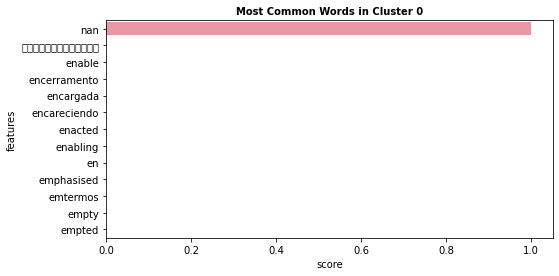

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38272 (\N{CJK UNIFIED IDEOGRAPH-9580}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32291 (\N{CJK UNIFIED IDEOGRAPH-7E23}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38568 (\N{CJK UNIFIED IDEOGRAPH-96A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33879 (\N{CJK UNIFIED IDEOGRAPH-8457}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

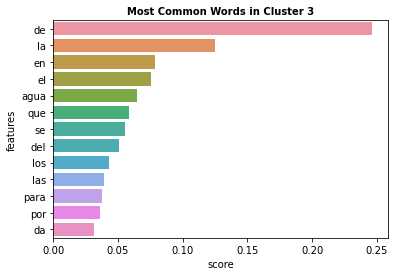

In [37]:
best_result = 3
kmeans = kmeans_results.get_params(best_result)


import matplotlib
final_df_array = final_df.to_numpy()

prediction = kmeans_results.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

### Map of Words
Making a map of words of each cluster

In [69]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [70]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

AttributeError: 'dict' object has no attribute 'cluster_centers_'

### Preparing final groups for visualization
Now that we're satisfied with our clustering we should assign which country belongs to which group.

In [71]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
data['label'] = labels
data.head()

AttributeError: 'dict' object has no attribute 'labels_'

### Visualization the Clustered Countries in a Map
Now that we have our final grouping it would be really cool to visualize it in a interactive map. To do this we'll use the awesome Folium library to see our interactive map!

We'll load a geojson file of polygons and country codes with geopandas and merge it with the labelled dataframe from the cell above.

In [72]:
# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = 'datasets/world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

data_to_plot.head(3)

CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

In [ ]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['r', 'y','g','b', 'm'], vmin=values.min(), vmax=values.max(), caption='step')

color_step

In [ ]:
import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig

In [ ]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)